In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import h5py
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import torch.nn.init as ini
import multiprocessing
from multiprocessing import Queue
import random
import pickle

class LocalPathConv(nn.Module):
    def __init__(self):
        super(LocalPathConv, self).__init__()
        self.local_conv1 = nn.Conv2d(4, 64, 7)
        self.dp1 = nn.Dropout2d(.5)
        self.local_conv2 = nn.Conv2d(64, 64, 3)
        self.dp2 = nn.Dropout2d(.5)
        self.total_conv = nn.Conv2d(64, 5, 21)

    def forward(self, x):
        x = self.local_conv1(x)
        x = self.dp1(x)
        x = F.max_pool2d(F.relu(x), 4, stride = 1)
        x = self.local_conv2(x)
        x = self.dp2(x)
        x = F.max_pool2d(F.relu(x), 2, stride = 1)
        x = self.total_conv(x)
        x = x.view(-1,5)
        return x
        
net = LocalPathConv()
net = net.cuda(1)
print(net)

x = Variable(torch.randn(1,4,33,33), requires_grad = True)
x = x.cuda(1)
y_pred = net.forward(x)
print(y_pred)

LocalPathConv (
  (local_conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
  (dp1): Dropout2d (p=0.5)
  (local_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (dp2): Dropout2d (p=0.5)
  (total_conv): Conv2d(64, 5, kernel_size=(21, 21), stride=(1, 1))
)
Variable containing:
-0.3778 -0.7241 -0.5513  0.8373 -0.5026
[torch.cuda.FloatTensor of size 1x5 (GPU 1)]



In [2]:
#1 phase train
train_file = open('/home/yiqin/two_path_cnn/training_list.pkl','rb')
val_file = open('/home/yiqin/two_path_cnn/HG0001_Val_list.pkl','rb')
f = h5py.File('/home/yiqin/train.h5','r')
train_list = pickle.load(train_file)
val_list = pickle.load(val_file)
train_file.close()
val_file.close()

In [3]:
print(len(train_list))
print(len(val_list))

8629298
368998


In [4]:
def create_val_batch_phase1(step = 300, key = 299):
    val_batch = []
    val_label = []
    batch_size = len(val_list) // step
    for i in range(batch_size):
        case,x,y,z,l = val_list.pop(i * step + key - i)
        x,y,z,l = int(x), int(y), int(z), int(l)
        case1 = case[0:2]
        case2 = case[3:]
        img_patch = f[case1][case2][:, x-16:x+16+1, y-16:y+16+1, z] #sample a 33x33 patch
        val_batch.append(img_patch)
        val_label.append(l)
    val_batch = torch.from_numpy(np.array(val_batch))
    val_label = torch.from_numpy(np.array(val_label))
    return val_batch, val_label

In [5]:
#create valid_set
val_len = len(val_list)

val_batch, val_y = create_val_batch_phase1()
val_y = val_y.view(-1)

print(len(val_list))
print(len(val_y))

367769
1229


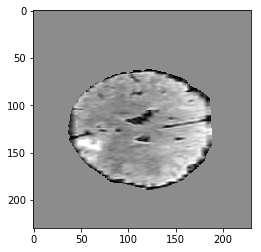

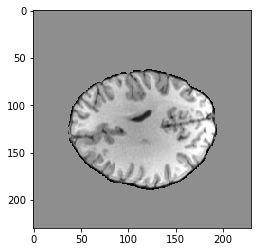

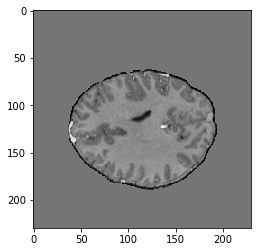

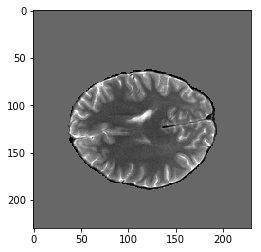

In [6]:
f = h5py.File('/home/yiqin/train.h5','r')
for i in range(4):
    plt.imshow(f['LG']['0015'][i,:,:,100], cmap = 'gray')
    plt.show()

In [7]:
#set hyper_param
learning_rate = 5e-3
l1_reg = 5e-5
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 5e-5)

In [8]:
for param in net.parameters():
    if len(param.size())==4:
        ini.uniform(param, a=-5e-3, b=5e-3)

In [9]:
def create_batch(size, j):
    train_batch = []
    train_label = []
    for i in range(size):
        case,x,y,z,l = train_list[j * size + i]
        x,y,z,l = int(x), int(y), int(z), int(l)
        case1 = case[0:2]
        case2 = case[3:]
        img_patch = f[case1][case2][:, x-16:x+16+1, y-16:y+16+1, z] #sample a 33x33 patch
        train_batch.append(img_patch)
        train_label.append(l)
    train_batch = torch.from_numpy(np.array(train_batch))
    train_label = torch.from_numpy(np.array(train_label))
    return train_batch, train_label

In [14]:
prev_time = time.clock()
num_epoch = 2
batch_size = 512
step_size = len(train_list) // batch_size
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
val_x = Variable(val_batch).cuda(1)
val_y = val_y.cuda(1)
val_batch_size = len(val_y)
l1_reg = 5e-5

for i in range(num_epoch):
    random.shuffle(train_list)
    for j in range(step_size):
        training_patch, training_label = create_batch(batch_size, j)
        x_train, y_train = Variable(training_patch.cuda(1)), Variable(training_label.cuda(1), requires_grad=False)
        y_pred = net.forward(x_train)
        y_pred = y_pred.view(-1,5)
        loss = F.cross_entropy(y_pred, y_train)#cross entropy loss

        l1_crit = nn.L1Loss(size_average = False)#L1 loss
        reg_loss = 0
        for param in net.parameters():
            target = Variable(torch.Tensor(param.size()).zero_()).cuda(1)
            reg_loss += l1_crit(param, target)
        loss+= l1_reg * reg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #check accuracy
        if j%10 == 0:
            print(loss)
            val_pred = net.forward(val_x)
            val_pred = val_pred.view(-1, 5)
            _, predicted = torch.max(val_pred.data, 1)
            correct = (predicted == val_y).sum()
            print('Validation accuracy:', float(correct) / val_batch_size)
            print('time used:%.3f'% (time.clock() - prev_time))
    scheduler.step()

KeyboardInterrupt: 

In [ ]:
torch.save(net, 'phase1_param.txt')

In [ ]:
#2nd phase train
normal_list = open('/home/yiqin/trainval.txt','r')
train_list = []
str2 = normal_list.readlines()
for i in range(len(str2)):
    train_list.append(str2[i][0:-1].split(' '))
print(len(train_list))
normal_list.close()

In [ ]:
def create_val_batch_phase2(batch_size):
    val_batch = []
    val_label = []
    for i in range(batch_size):
        case,x,y,z,l = train_list.pop()
        x,y,z,l = int(x), int(y), int(z), int(l)
        case1 = case[0:2]
        case2 = case[3:]
        img_patch = f[case1][case2][:, x-16:x+16+1, y-16:y+16+1, z] #sample a 33x33 patch
        val_batch.append(img_patch)
        val_label.append(l)
    val_batch = torch.from_numpy(np.array(val_batch))
    val_label = torch.from_numpy(np.array(val_label))
    return val_batch, val_label

In [ ]:
prev_time = time.clock()
random.shuffle(train_list)
print(time.clock()-prev_time)

In [ ]:
val_size = 10000
val_x, val_y = create_val_batch_phase2(val_size)
print(val_y)

In [ ]:
print(len(train_list))

In [ ]:
net = LocalPathConv()
net.load_state_dict(torch.load("phase1_param.txt"))
learning_rate = 5e-4
optimizer = torch.optim.SGD(net.total_conv.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 5e-5)

prev_time = time.clock()
num_epoch = 2
batch_size = 512
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

for i in range(num_epoch):
    random.shuffle(train_list)
    for j in range(step_size):
        training_patch, training_label = create_batch(batch_size, j)
        x_train, y_train = Variable(training_patch.cuda(1)), Variable(training_label.cuda(1), requires_grad=False)
        y_pred = net.forward(x_train)
        y_pred = y_pred.view(-1,5)
        loss = F.cross_entropy(y_pred, y_train)#cross entropy loss

#        l1_crit = nn.L1Loss(size_average = False)#L1 loss
#        reg_loss = 0
#        for param in net.parameters():
#            reg_loss += l1_crit(param)
#        loss+= l1_reg * reg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #check accuracy
        if j%10 == 0:
            print(loss)
            val_pred = net.forward(val_x)
            val_pred = val_pred.view(-1, 5)
            _, predicted = torch.max(val_pred.data, 1)
            correct = (predicted == val_y).sum()
            print('Validation accuracy:', float(correct) / val_patch_size)
            print('time used:%.3f'% (time.clock() - prev_time))
    scheduler.step()

In [ ]:
f.close()